In [1]:
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
%matplotlib inline 

## Let's start from linear SVM 
from sklearn.svm import LinearSVC
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
from sklearn import svm

from tqdm import tqdm # for progressive bar

from sklearn.externals import joblib # to save model


## load one epoch data

In [2]:
def load_one_epoch(subject, data_type, epoch_num):
    if data_type is 'train':
        epoch_data=loadmat("data/{}{}-allfilt20.mat".format(subject, epoch_num))

    x=epoch_data['x']
    y=epoch_data['y']

    return x, y

In [3]:
#subject='A'
subject='B'
epoch_num = 1
x, y = load_one_epoch(subject, 'train', 1)

print(x.shape)
print(y.shape)

(180, 896)
(180, 1)


## load all training data for a subject

In [4]:
def load_data(subject, data_type, num_epoches):
    X = list()
    Y = list()
    for epoch_num in range(num_epoches):
        #print(epoch_num)
        x, y = load_one_epoch(subject, data_type, 1+epoch_num)

        X.append(x)
        Y.append(y)


    X = np.array(X)
    Y = np.array(Y)

    print('loaded:')
    print(X.shape)
    print(Y.shape)

    num_trials = X.shape[1]
    data_dim = X.shape[2]

    # stack epoches
    X = X.reshape(-1,data_dim)
    Y = Y.reshape(-1,1)

    print('stacked:')
    print(X.shape)
    print(Y.shape)
    
    return X, Y

In [6]:

#subject = 'A'
subject = 'B'
num_epoches = 85

X_train, Y_train = load_data(subject, 'train', num_epoches)



loaded:
(85, 180, 896)
(85, 180, 1)
stacked:
(15300, 896)
(15300, 1)


## load and apply channel masks 

In [7]:
def load_channel_mask(subject, num_channels):
    return np.loadtxt('mask/{}_chosen_channel_mask_{}.txt'.format(subject,num_channels), dtype=int)

In [8]:
#num_chosen_channels=2
num_chosen_channels=4
mask = load_channel_mask(subject,num_chosen_channels)
#plt.plot(mask)
print(mask)

[0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [9]:
def apply_mask(X, mask):
    data_dim = X.shape[1]
    num_channels = len(mask)
    samples_per_channel = int(data_dim / num_channels)
    
#     print(X.shape)
#     print(data_dim)
#     print(num_channels)
#     print(samples_per_channel)    
    
    index = np.repeat(mask,samples_per_channel)
    
#     print(mask)
#     print(np.repeat(mask,samples_per_channel))

    return X[:,index>0]

In [10]:
X_train_chosen=apply_mask(X_train, mask)
X_train_chosen.shape

(15300, 56)

In [11]:
Y_train.shape

(15300, 1)

## Try training without scaling

In [12]:
# try training
clf = svm.LinearSVC(C=10, loss="hinge", max_iter=5000, random_state=42)  # class_weight='balanced',

clf.fit(X_train_chosen,Y_train.ravel())

/Users/yyoo/tf11/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0)

In [13]:
# training classfication error
Yhat = clf.predict(X_train_chosen)
print(np.mean(Y_train==Yhat))
print(np.std(Y_train==Yhat))

0.7178213507625273
0.45005983952357936


## Scaling matters!

In [14]:
## with scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=10, loss="hinge", max_iter=5000, random_state=42)), # class_weight='balanced', 
    ])

clf.fit(X_train_chosen,Y_train.ravel())

/Users/yyoo/tf11/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [15]:
# training classfication error
Yhat = clf.predict(X_train_chosen)
print(np.mean(Y_train==Yhat))
print(np.std(Y_train==Yhat))

## SCALING IS IMPORTANT!

0.8333333333333334
0.37267799625000436


In [ ]:
## TODO


## Let's do cross-validation



  0%|          | 0/9 [00:00<?, ?it/s]

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
number of chosen channels=2




 11%|█         | 1/9 [00:01<00:12,  1.54s/it]

 22%|██▏       | 2/9 [00:02<00:08,  1.24s/it]

 33%|███▎      | 3/9 [00:02<00:06,  1.03s/it]

 44%|████▍     | 4/9 [00:03<00:04,  1.11it/s]

 56%|█████▌    | 5/9 [00:04<00:03,  1.00it/s]

 67%|██████▋   | 6/9 [00:13<00:10,  3.37s/it]

 78%|███████▊  | 7/9 [00:23<00:10,  5.32s/it]

 89%|████████▉ | 8/9 [00:33<00:06,  6.76s/it]

100%|██████████| 9/9 [00:43<00:00,  7.74s/it]



max accuracy = 0.83 when C=10^-4




  0%|          | 0/9 [00:00<?, ?it/s]

number of chosen channels=4




 11%|█         | 1/9 [00:00<00:05,  1.48it/s]

 22%|██▏       | 2/9 [00:01<00:04,  1.49it/s]

 33%|███▎      | 3/9 [00:01<00:03,  1.74it/s]

 44%|████▍     | 4/9 [00:02<00:02,  1.67it/s]

 56%|█████▌    | 5/9 [00:05<00:05,  1.47s/it]

 67%|██████▋   | 6/9 [00:19<00:15,  5.19s/it]

 78%|███████▊  | 7/9 [00:34<00:16,  8.00s/it]

 89%|████████▉ | 8/9 [00:49<00:10, 10.05s/it]

100%|██████████| 9/9 [01:03<00:00, 11.48s/it]



max accuracy = 0.83 when C=10^-4




  0%|          | 0/9 [00:00<?, ?it/s]

number of chosen channels=8




 11%|█         | 1/9 [00:00<00:04,  1.69it/s]

 22%|██▏       | 2/9 [00:01<00:05,  1.38it/s]

 33%|███▎      | 3/9 [00:02<00:04,  1.36it/s]

 44%|████▍     | 4/9 [00:03<00:04,  1.00it/s]

 56%|█████▌    | 5/9 [00:14<00:15,  3.88s/it]

 67%|██████▋   | 6/9 [00:36<00:28,  9.39s/it]

 78%|███████▊  | 7/9 [00:59<00:26, 13.45s/it]

 89%|████████▉ | 8/9 [01:23<00:16, 16.42s/it]

100%|██████████| 9/9 [01:46<00:00, 18.45s/it]



max accuracy = 0.83 when C=10^-4




  0%|          | 0/9 [00:00<?, ?it/s]

number of chosen channels=16




 11%|█         | 1/9 [00:01<00:09,  1.14s/it]

 22%|██▏       | 2/9 [00:02<00:09,  1.29s/it]

 33%|███▎      | 3/9 [00:04<00:08,  1.46s/it]

 44%|████▍     | 4/9 [00:08<00:10,  2.20s/it]

 56%|█████▌    | 5/9 [00:39<00:43, 10.84s/it]

 67%|██████▋   | 6/9 [01:13<00:53, 17.79s/it]

 78%|███████▊  | 7/9 [01:48<00:46, 23.06s/it]

 89%|████████▉ | 8/9 [02:24<00:26, 26.81s/it]

100%|██████████| 9/9 [02:59<00:00, 29.40s/it]



max accuracy = 0.83 when C=10^-4
number of chosen channels=32




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:02<00:19,  2.42s/it]

 22%|██▏       | 2/9 [00:16<00:40,  5.84s/it]

 33%|███▎      | 3/9 [00:21<00:34,  5.75s/it]

 44%|████▍     | 4/9 [00:34<00:39,  7.88s/it]

 56%|█████▌    | 5/9 [01:22<01:19, 19.79s/it]

 67%|██████▋   | 6/9 [02:11<01:26, 28.72s/it]

 78%|███████▊  | 7/9 [03:04<01:11, 35.90s/it]

 89%|████████▉ | 8/9 [03:57<00:41, 41.09s/it]

100%|██████████| 9/9 [04:50<00:00, 44.58s/it]



max accuracy = 0.83 when C=10^-4
number of chosen channels=64




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:04<00:33,  4.13s/it]

 22%|██▏       | 2/9 [00:46<01:49, 15.60s/it]

 33%|███▎      | 3/9 [00:59<01:29, 14.84s/it]

 44%|████▍     | 4/9 [01:44<01:58, 23.74s/it]

 56%|█████▌    | 5/9 [02:48<02:23, 35.83s/it]

 67%|██████▋   | 6/9 [03:53<02:14, 44.83s/it]

 78%|███████▊  | 7/9 [05:06<01:46, 53.04s/it]

 89%|████████▉ | 8/9 [06:18<00:58, 58.84s/it]

100%|██████████| 9/9 [07:30<00:00, 62.91s/it]



max accuracy = 0.83 when C=10^-4


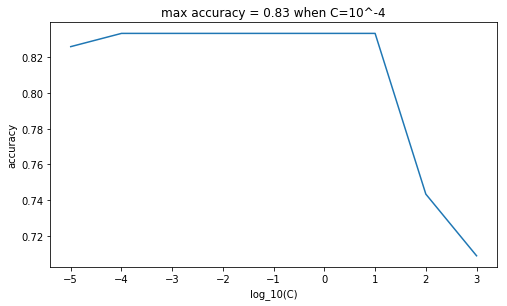

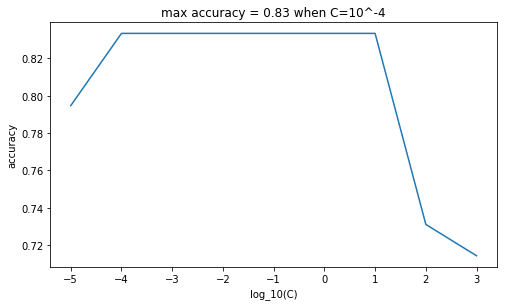

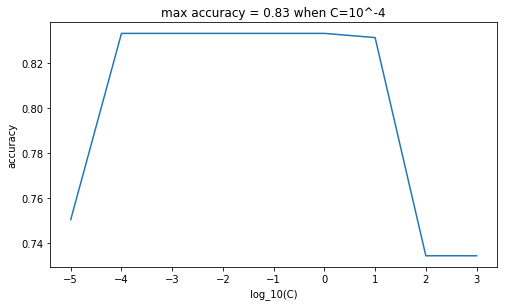

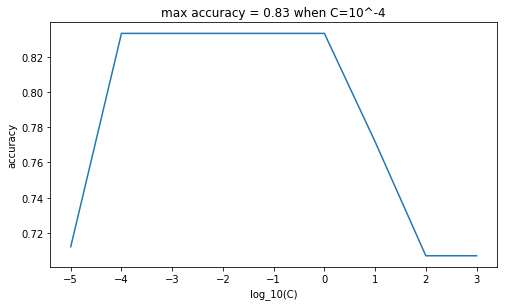

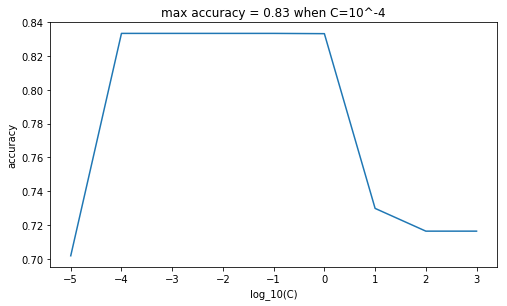

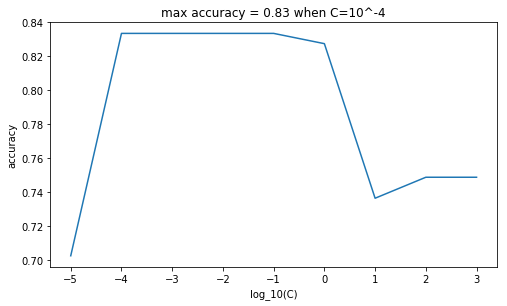

In [73]:
# repeat cross-validation for a wide range of C
from sklearn.model_selection import cross_val_score

#Cs = 10**np.linspace(-20,20,41)
Cs = 10**np.linspace(-5,3,9)
print(Cs)
k = 5

for num_chosen_channels in (2, 4, 8, 16, 32, 64):
    print("number of chosen channels={}".format(num_chosen_channels))
    mask = load_channel_mask(subject,num_chosen_channels)

    X_train_chosen=apply_mask(X_train, mask)
    X_train_chosen.shape


    accuracy = list()
    for C in tqdm(Cs):
        # model: linear SVM 
        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("linear_svc", LinearSVC(C=C, loss="hinge",  random_state=42)), # class_weight='balanced',
        ])   
    
        accuracy.append(cross_val_score(clf, X_train_chosen, Y_train.ravel(), cv=k, n_jobs=-1))

        
    # calc mean accuracy
    mean_accuracy = np.mean(accuracy,axis=1)
    #print(mean_accuracy)

    maxIdx=np.argmax(mean_accuracy)
    print("max accuracy = {:.2f} when C=10^{:.0f}".format(mean_accuracy[maxIdx], np.log10(Cs[maxIdx])))

    np.savetxt("{}_training_accuracy_SVM_ch{}.txt".format(subject,num_chosen_channels), mean_accuracy, fmt="%.2f")

    
    # save model    
    joblib.dump(clf, "{}_model_SVM_ch{}.model".format(subject,num_chosen_channels)) 
    

    # plot results
    plt.figure(figsize=(8, 4.5))

    plt.plot(np.log10(Cs),mean_accuracy)
    #plt.plot(np.log10(Cs), baseAcc*np.ones_like(Cs), '--')
    plt.xlabel('log_10(C)')
    plt.ylabel('accuracy')

    plt.title("max accuracy = {:.2f} when C=10^{:.0f}".format(mean_accuracy[maxIdx], np.log10(Cs[maxIdx])))
    
    plt.savefig("{}_training_accuracy_SVM_ch{}.pdf".format(subject,num_chosen_channels))
    plt.savefig("{}_training_accuracy_SVM_ch{}.png".format(subject,num_chosen_channels))


## Combine and plot 

In [74]:
accuracy = list()
Chs = (2, 4, 8, 16, 32, 64)
for num_chosen_channels in Chs:
    mean_accuracy = np.loadtxt("{}_training_accuracy_SVM_ch{}.txt".format(subject,num_chosen_channels))
    accuracy.append(mean_accuracy)

accuracy = np.array(accuracy)
accuracy.shape

(6, 9)

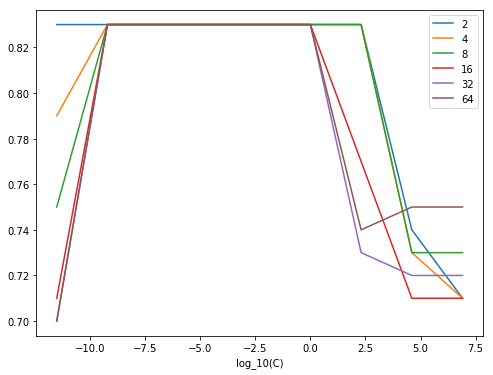

In [75]:
plt.figure(figsize=(8,6))

plt.plot(np.log(Cs), accuracy.transpose())
plt.legend(Chs)
plt.xlabel('log_10(C)')

plt.savefig("{}_training_accuracy_SVM.pdf".format(subject))
plt.savefig("{}_training_accuracy_SVM.png".format(subject))

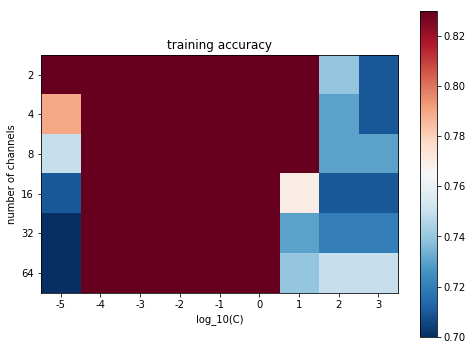

In [76]:

plt.figure(figsize=(8,6))

plt.imshow(accuracy, cmap='RdBu_r',interpolation="none")
plt.colorbar()
plt.xticks(range(len(Cs)), ["{:.0f}".format(np.log10(x)) for x in Cs])
plt.xlabel('log_10(C)')
plt.yticks(range(len(Chs)), ["{:.0f}".format(y) for y in Chs])
plt.ylabel('number of channels')
plt.title('training accuracy')

plt.savefig("{}_training_accuracy_SVM_image.pdf".format(subject))
plt.savefig("{}_training_accuracy_SVM_image.png".format(subject))


    

## Joint training

In [67]:
# load data
num_epoches = 85

X_train_A, Y_train_A = load_data('A', 'train', num_epoches)
X_train_B, Y_train_B = load_data('B', 'train', num_epoches)

loaded:
(85, 180, 896)
(85, 180, 1)
stacked:
(15300, 896)
(15300, 1)
loaded:
(85, 180, 896)
(85, 180, 1)
stacked:
(15300, 896)
(15300, 1)


In [68]:
# combine
X_train = np.vstack((X_train_A,X_train_B))
print(X_train.shape)
Y_train = np.vstack((Y_train_A, Y_train_B))
print(Y_train.shape)

(30600, 896)
(30600, 1)


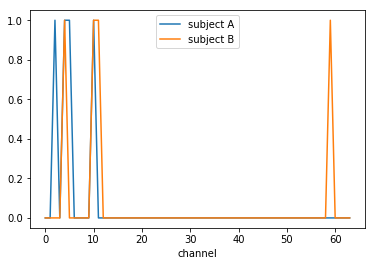

In [61]:
#num_chosen_channels=2
num_chosen_channels=4
mask_A = load_channel_mask('A',num_chosen_channels)
mask_B = load_channel_mask('B',num_chosen_channels)

plt.plot(mask_A)
plt.plot(mask_B)
plt.xlabel('channel')
plt.legend(('subject A','subject B'))
#print(mask)

In [62]:
# combine mask by AND
subject='AandB'
Chs = (2, 4, 8, 16, 32, 64)
for num_chosen_channels in Chs:
    mask_A = load_channel_mask('A',num_chosen_channels)
    mask_B = load_channel_mask('B',num_chosen_channels)
    
    mask_AB = mask_A*mask_B
    np.savetxt('mask/{}_chosen_channel_mask_{}.txt'.format(subject,num_chosen_channels), mask_AB, fmt="%d")

In [ ]:
# run the cross validation block



In [70]:
# combine mask by OR
subject='AorB'
Chs = (2, 4, 8, 16, 32, 64)
for num_chosen_channels in Chs:
    mask_A = load_channel_mask('A',num_chosen_channels)
    mask_B = load_channel_mask('B',num_chosen_channels)
    
    mask_AB = 1-(1-mask_A)*(1-mask_B)
    np.savetxt('mask/{}_chosen_channel_mask_{}.txt'.format(subject,num_chosen_channels), mask_AB, fmt="%d")

In [71]:
# run the cross validation block



In [72]:
subject

'AorB'

## Load test data

**below is old code from https://github.com/ys7yoo/human-plus/blob/master/classifyUsingSVM.ipynb**


## Adding `balancing` 


In [ ]:
# repeat for a wide range of C
Cs = 10**np.linspace(-20,20,41)
Cs

k = 5
scores = list()
for C in Cs:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=C, loss="hinge",  class_weight='balanced', random_state=42)),  # balanced!
    ])

    scores.append(cross_val_score(clf, X, Y, cv=k))
    
#scores

mean_scores_balanced = np.mean(scores,axis=1)
#print(mean_scores_balanced)

maxIdx=np.argmax(mean_scores_balanced)
print("max accuracy = {} when C={}".format(mean_scores_balanced[maxIdx], Cs[maxIdx]))




import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log10(Cs),mean_scores)
plt.plot(np.log10(Cs),mean_scores_balanced)
plt.plot(np.log10(Cs), baseAcc*np.ones_like(Cs), '--')
plt.legend(('equal weight','balanced', 'baseline'))
plt.xlabel('log_10(C)')
plt.ylabel('accuracy')
    

In [ ]:
# let's repeat & check confusion matrix!

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=10, loss="hinge", random_state=42)),  # balanced!
    #("linear_svc", LinearSVC(C=10, loss="hinge",  class_weight='balanced', random_state=42)),  # balanced!
])
    

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

split = StratifiedShuffleSplit(n_splits=5, test_size=1/5, random_state=42)

k = 0

acc_train = list()
acc_test = list()
for train_index, test_index in split.split(X,Y):
#    print(train_index)
#    print(test_index)
    if k==0:   # print info
        print("In the training set of size{},".format(Y[train_index].shape))
        print("cor: {}, incor: {}".format(sum(Y[train_index]==1),sum(Y[train_index]==-1)))
        print("In the training set of size{},".format(Y[test_index].shape))    
        print("cor: {}, incor: {}".format(sum(Y[test_index]==1),sum(Y[test_index]==-1)))
        baseAcc = sum(Y[test_index]==1) / (sum(Y[test_index]==1)+sum(Y[test_index]==-1)) 
        print("base accuracy = {}".format(baseAcc))

    X_train = X[train_index,:]
    Y_train = Y[train_index]
    X_test = X[test_index,:]    
    Y_test = Y[test_index]
    
    clf.fit(X_train,Y_train)

    # training error
    Yhat_train = clf.predict(X_train)
    acc_train.append(np.mean(Yhat_train==Y_train))

    # test error
    Yhat_test = clf.predict(X_test)
    acc_test.append(np.mean(Yhat_test==Y_test))
 
    cm = confusion_matrix(Y_test, Yhat_test, labels=(1,-1))
    print(cm)

#     # let's manually check
#     print(sum((Y_test == 1) & (Yhat_test == 1)))    # 1s are (correctly) predicted as 1s
#     print(sum((Y_test == 1) & (Yhat_test == -1)))   # 1s are predicted as -1
#     print(sum((Y_test == -1) & (Yhat_test == 1)))   # -1s are predicted as 1
#     print(sum((Y_test == -1) & (Yhat_test == -1)))  # -1s are (correctly) predicted as -1

    
    k = k + 1
print("training accuracy")    
print(acc_train)
print("test accuracy")    
print(acc_test)
print(np.mean(acc_test))

In [ ]:
# re-train using all the data (CAN I DO THIS?)

clf.fit(X,Y)

# get coefficient of SVM
w = clf.named_steps['linear_svc'].coef_
w = w.ravel()
#w.shape
plt.plot(w)
plt.ylabel('w')
plt.xlabel('feature index')


w.shape
#listSelectedFeature.shape
listSelectedFeature[w>0.1,:]

listSelectedFeature[w<-0.1,:]


## So, conclusions are
* linear SVM does *NOT* work for p<0.05
* linear SVM does workf for p<0.1

## Nonlinear SVMs

In [ ]:
from sklearn.pipeline import Pipeline

rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", svm.SVC(kernel="rbf", gamma=2, C=10,random_state=42))   # class_weight='balanced',
    ])
    
rbf_kernel_svm_clf.fit(X, Y)

Yhat=rbf_kernel_svm_clf.predict(X)
print(np.mean(Y==Yhat))
plt.plot(Yhat)

## Cross validation with nonlinear SVM

In [ ]:
# repeat for a wide range of gamma and C

Gs=2**np.linspace(-7,3,11)
Gs
Cs = 10**np.linspace(-20,20,41)
Cs


# unbalanced 
k = 5
gs = list()
cs = list()
scores = list()
for G in Gs:
    print("gamma={}".format(G))
    for C in Cs:
        rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", svm.SVC(kernel="rbf", gamma=G, C=C,random_state=42))   # class_weight='balanced',
        ])
        gs.append(G)
        cs.append(C)
        scores.append(cross_val_score(rbf_kernel_svm_clf, X, Y, cv=k))


mean_scores = np.mean(scores,axis=1)
#print(mean_scores)    


maxIdx=np.argmax(mean_scores)
print("max accuracy = {} when gamma={} and C={}".format(mean_scores[maxIdx], gs[maxIdx], cs[maxIdx]))




# save results to files
np.savetxt("gamma.txt", gs)
np.savetxt("C.txt", Cs)
np.savetxt("scores.txt", scores)
np.savetxt("mean_scores.txt", mean_scores)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mean_scores)
#plt.plot(np.log10(Cs), mean_scores)
plt.plot(baseAcc*np.ones_like(mean_scores), '--')
plt.xlabel('(gamma,C)')
plt.ylabel('accuracy')

In [ ]:
0.8905555555555555*9

## add balance

In [ ]:
## add balance

Gs=2**np.linspace(-7,3,11)
Gs
Cs = 10**np.linspace(-20,20,41)
Cs


# unbalanced 
k = 5
gs = list()
cs = list()
scores_balanced = list()
for G in Gs:
    print("gamma={}".format(G))
    for C in Cs:
        rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", svm.SVC(kernel="rbf", gamma=G, C=C, class_weight='balanced', random_state=42))   # ,
        ])
        gs.append(G)
        cs.append(C)
        scores_balanced.append(cross_val_score(rbf_kernel_svm_clf, X, Y, cv=k))


mean_scores_balanced = np.mean(scores_balanced,axis=1)
#print(mean_scores)    


maxIdx=np.argmax(mean_scores_balanced)
print("max accuracy = {} when gamma={} and C={}".format(mean_scores_balanced[maxIdx], gs[maxIdx], cs[maxIdx]))




# save results to files
np.savetxt("gamma_balanced.txt", gs)
np.savetxt("C_balanced.txt", Cs)
np.savetxt("scores_balanced.txt", scores_balanced)
np.savetxt("mean_scores_balanced.txt", mean_scores_balanced)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mean_scores)
#plt.plot(np.log10(Cs), mean_scores)
plt.plot(baseAcc*np.ones_like(mean_scores), '--')
plt.xlabel('(gamma,C)')
plt.ylabel('accuracy')

In [ ]:
# refit using the best param
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", svm.SVC(kernel="rbf", gamma=0.03125, C=1, class_weight='balanced', random_state=42))   # ,
])

rbf_kernel_svm_clf.fit(X,Y)

# training error = 0
Yhat = rbf_kernel_svm_clf.predict(X)
np.mean(Yhat==Y)

In [ ]:
# let's repeat & check confusion matrix!

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

split = StratifiedShuffleSplit(n_splits=5, test_size=1/5, random_state=42)

k = 0

acc_train = list()
acc_test = list()
for train_index, test_index in split.split(X,Y):
#    print(train_index)
#    print(test_index)
    if k==0:   # print info
        print("In the training set of size{},".format(Y[train_index].shape))
        print("cor: {}, incor: {}".format(sum(Y[train_index]==1),sum(Y[train_index]==-1)))
        print("In the training set of size{},".format(Y[test_index].shape))    
        print("cor: {}, incor: {}".format(sum(Y[test_index]==1),sum(Y[test_index]==-1)))
        baseAcc = sum(Y[test_index]==1) / (sum(Y[test_index]==1)+sum(Y[test_index]==-1)) 
        print("base accuracy = {}".format(baseAcc))

    X_train = X[train_index,:]
    Y_train = Y[train_index]
    X_test = X[test_index,:]    
    Y_test = Y[test_index]
    
    rbf_kernel_svm_clf.fit(X_train,Y_train)

    # training error
    Yhat_train = rbf_kernel_svm_clf.predict(X_train)
    acc_train.append(np.mean(Yhat_train==Y_train))

    # test error
    Yhat_test = rbf_kernel_svm_clf.predict(X_test)
    acc_test.append(np.mean(Yhat_test==Y_test))
 
    cm = confusion_matrix(Y_test, Yhat_test, labels=(1,-1))
    print(cm)

#     # let's manually check
#     print(sum((Y_test == 1) & (Yhat_test == 1)))    # 1s are (correctly) predicted as 1s
#     print(sum((Y_test == 1) & (Yhat_test == -1)))   # 1s are predicted as -1
#     print(sum((Y_test == -1) & (Yhat_test == 1)))   # -1s are predicted as 1
#     print(sum((Y_test == -1) & (Yhat_test == -1)))  # -1s are (correctly) predicted as -1

    
    k = k + 1
print("training accuracy")    
print(acc_train)
print("test accuracy")    
print(acc_test)
print(np.mean(acc_test))
print(np.std(acc_test))

In [ ]:
Yhat_test

In [ ]:
8/9